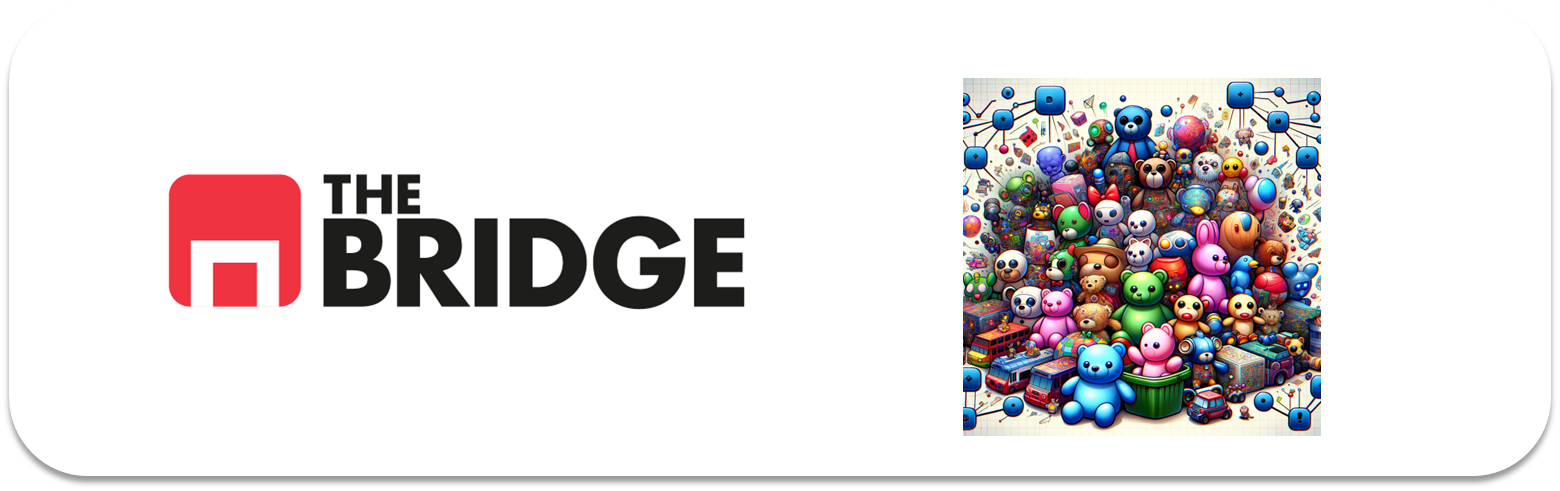

## PRACTICA OBLIGATORIA: **K-Means Clustering**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [3]:

data = fetch_olivetti_faces()
X = data.data      # (400, 4096) -> cada fila es una cara "aplanada"
y = data.target    # etiqueta de persona (0..39) - OJO: para clustering NO la usamos

print("X:", X.shape, "y:", y.shape)


X: (400, 4096) y: (400,)


In [4]:
print(X.shape)
print(y.shape)

print("Min:", X.min())
print("Max:", X.max())


(400, 4096)
(400,)
Min: 0.0
Max: 1.0


In [5]:
# valores del target
print("Personas únicas:", np.unique(y))
print("Número total de personas:", len(np.unique(y)))


Personas únicas: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Número total de personas: 40


In [6]:
# Ver distribución - # Comprueba: si hay el mismo número de imágenes por persona.
pd.Series(y).value_counts().sort_index()


0     10
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
11    10
12    10
13    10
14    10
15    10
16    10
17    10
18    10
19    10
20    10
21    10
22    10
23    10
24    10
25    10
26    10
27    10
28    10
29    10
30    10
31    10
32    10
33    10
34    10
35    10
36    10
37    10
38    10
39    10
Name: count, dtype: int64

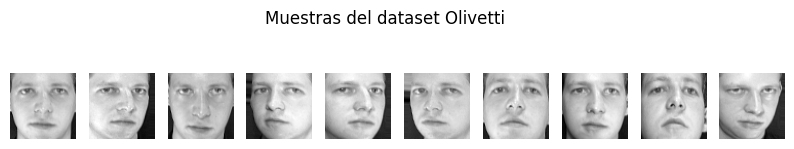

In [7]:
def plot_faces(X_flat, n=10, title=""):
    """
    X_flat: array (n_samples, 4096) con caras aplanadas
    n: número de caras a mostrar
    """
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X_flat[i].reshape(64, 64), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_faces(X, n=10, title="Muestras del dataset Olivetti")


In [8]:
# Revisar rango de valores
print("Valor mínimo:", X.min())
print("Valor máximo:", X.max())
print("Media:", X.mean())


Valor mínimo: 0.0
Valor máximo: 1.0
Media: 0.5470425


In [9]:
# =========================
# Preprocesado SOLO con StandardScaler 
# =========================

from sklearn.preprocessing import StandardScaler

# 1️⃣ Crear el scaler
scaler = StandardScaler()

# 2️⃣ Ajustar y transformar los datos
# fit = aprende media y desviación
# transform = aplica el escalado
X_scaled = scaler.fit_transform(X)

print("Shape después de escalar:", X_scaled.shape)


Shape después de escalar: (400, 4096)


El dataset presenta valores entre 0 y 1, por lo que ya se encuentra normalizado. Sin embargo, se aplica StandardScaler para centrar los datos y mejorar el comportamiento del algoritmo KMeans basado en distancias.

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [32]:
data.data

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], shape=(400, 4096), dtype=float32)

In [11]:
print(y[:20]) # Mostrar target


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [ ]:

# Crear dataframe con features con los datos del escalado  - TENDREMOS QUE ESTANDARIZAR ---
df = pd.DataFrame(X_scaled)

# Añadir target
df["target"] = y

df.head()


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,-0.499903,-0.351181,-0.302961,-0.395361,-0.137608,0.104953,0.213296,0.194894,0.171393,0.065267,...,1.663788,1.598077,1.621725,0.726428,-1.092090,-0.959562,-0.898275,-0.831520,-0.850457,0
1,0.301499,0.194640,0.185686,0.203914,0.213404,0.290404,0.361849,0.355027,0.311534,0.180529,...,-1.157252,-1.249632,-1.096954,-1.007794,-0.982783,-0.938375,-0.898275,-0.876585,-0.873362,0
2,-0.454109,-0.176519,0.079458,0.054095,0.169528,0.383129,0.361849,0.248272,0.255477,0.151713,...,-1.293754,-0.999033,-1.162729,-1.141196,-1.004644,-0.980749,-0.964353,-0.899118,-0.873362,0
3,-1.118128,-1.268161,-1.450221,-1.679522,-1.936544,-2.236356,-2.262576,-1.566562,-1.230019,-1.116165,...,1.481785,1.620859,1.753274,2.082678,2.143408,2.197309,2.295495,2.390682,2.379126,0
4,0.553368,0.587631,0.546860,0.546357,0.498602,0.568579,0.436125,0.435093,0.395618,0.382236,...,-1.134502,-1.021815,-0.965405,-0.874393,-0.851614,-0.811252,-0.766119,-0.763921,-0.758838,0


In [13]:
# Reordenamos aleatoriamente las observaciones para evitar posibles sesgos derivados del orden original.
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

df_shuffled.head()


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,-1.118128,-1.049833,-0.642890,-0.566583,-0.708002,-0.891842,-0.727535,-0.765900,-0.949737,-0.856826,...,0.776525,0.891845,0.788581,0.770895,0.700551,-0.260389,-1.382847,-1.011783,-1.216934,20
1,-1.186820,-1.617487,-1.853886,-2.000562,-1.958483,-1.795912,-1.123675,-0.685834,-0.641426,-0.626303,...,0.162267,0.253959,-0.285736,0.437391,0.656828,-0.451072,-0.700041,-0.561125,-0.552694,28
2,0.599163,0.893291,0.738070,0.567760,0.542478,0.429491,0.411366,0.515159,0.535760,0.641575,...,-0.360991,-0.315583,-0.219961,-0.073982,0.000984,-0.027331,0.070869,0.159927,0.180261,3
3,-1.461586,-1.551988,-1.492712,-1.230066,-1.256458,-1.262742,-1.272227,-1.486496,-1.538330,-1.548395,...,-1.089001,-0.862343,-0.417285,0.081653,1.837348,1.667633,-0.215469,0.317657,-0.186216,21
4,1.400565,1.111620,0.908035,0.974411,0.849614,0.730848,0.733229,0.648603,0.563788,0.555129,...,-1.612258,-1.591357,-1.447752,-1.385766,-1.201397,-1.362116,-1.250691,-0.696322,-0.438170,9


### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [14]:
# separamos X - Y KMeans no usa target. Pero split sí necesita target.
X_all = df_shuffled.drop(columns=["target"])
y_all = df_shuffled["target"]


In [15]:
# Primer split (80% train + 20% temp)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=42
)


In [16]:
# Segundo split (10% val + 10% test) - Ahora dividimos el 20%.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)


### #1.4

Crea los pares X,y para train, validation y test.

In [17]:
# =========================
# #1.4 Pares X,y
# =========================

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (320, 4096) (320,)
Validation: (40, 4096) (40,)
Test: (40, 4096) (40,)


Se crean los pares X e y para los conjuntos de entrenamiento, validación y test a partir de la división estratificada realizada previamente.

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [18]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

In [19]:
X_train
y_train


383    13
362     5
140     3
234    12
399    10
       ..
225    19
376    27
315    21
393     2
85      6
Name: target, Length: 320, dtype: int64

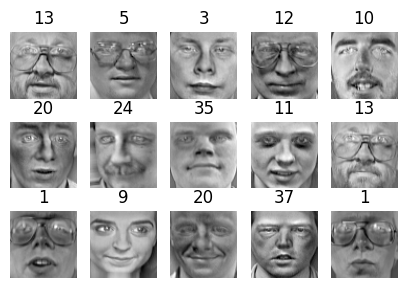

In [20]:
# Seleccionar primeras 15 imágenes
faces_sample = X_train.iloc[:15].values
labels_sample = y_train.iloc[:15].values

# Llamar función
plot_faces(faces_sample, labels_sample)


In [21]:
print(faces_sample.shape)


(15, 4096)


### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [22]:
from sklearn.decomposition import PCA   # Importar PCA

pca = PCA(0.99)                         # Mantener 99% de la varianza (reduce dimensiones automáticamente), conserva suficiente información

X_train_pca = pca.fit_transform(X_train)  # Aprender PCA con TRAIN + transformar datos
X_valid_pca = pca.transform(X_val)        # Transformar VALID usando PCA ya aprendido
X_test_pca = pca.transform(X_test)        # Transformar TEST sin volver a entrenar

pca.n_components_                         # Número final de componentes tras reducción


np.int64(221)

PCA ah reducido de 4096 → 221 features  
👉 menos dimensiones pero manteniendo la información importante. PCA  buscará el número mínimo de nuevas variables que expliquen el 99% de la información.

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []                        # Lista para guardar resultados
k_values = range(5, 151, 5)           # Probar K desde 5 hasta 150

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)   # Crear modelo
    labels = kmeans.fit_predict(X_train_pca)         # Entrenar con PCA train
    
    score = silhouette_score(X_train_pca, labels)   # Calcular silhouette
    sil_scores.append(score)                        # Guardar resultado

# Ver mejor K
best_k = k_values[sil_scores.index(max(sil_scores))]
print("Mejor K:", best_k)
print("Mejor silhouette:", max(sil_scores))


Mejor K: 105
Mejor silhouette: 0.20377036929130554


+1   → clusters muy bien separados  
0.5  → bastante buenos  
0.25 → aceptables   
0    → puntos mezclados  
<0   → mal clustering  
valor ≈ 0.20 clustering aceptable  

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

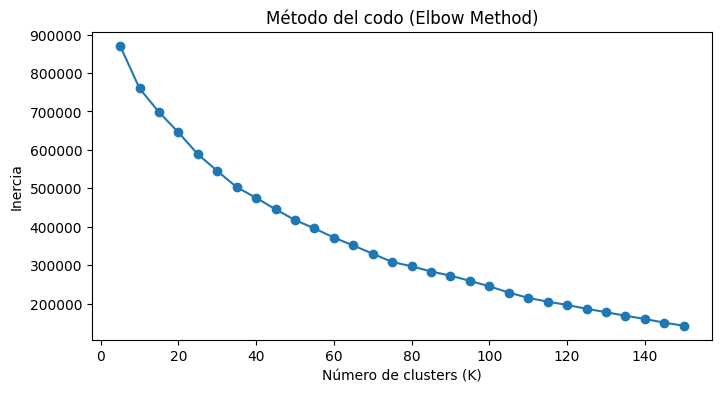

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inercias = []                         # Guardar valores de inercia
k_values = range(5,151,5)             # Mismos K que antes

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)           # Entrenar con PCA
    
    inercias.append(kmeans.inertia_)  # Guardar inercia

# Graficar método del codo
plt.figure(figsize=(8,4))
plt.plot(k_values, inercias, marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del codo (Elbow Method)")
plt.show()


El método del codo no muestra un punto de inflexión claramente definido, ya que la inercia disminuye de forma progresiva al aumentar el número de clusters. Por tanto, no proporciona una conclusión clara y se refuerza la necesidad de utilizar otras métricas como el silhouette score para seleccionar el valor óptimo de K.  
El valor máximo del silhouette score se obtiene para K=105 con un valor aproximado de 0.20, lo que indica una separación moderada entre clusters. Esto sugiere que, aunque existe cierta estructura en los datos, los grupos no están claramente definidos, lo cual es esperable en datasets de imágenes faciales.  

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [25]:
from sklearn.cluster import KMeans

# Crear modelo final usando el mejor K obtenido
best_model = KMeans(n_clusters=best_k, random_state=42)   # Modelo final

# Entrenar modelo con datos PCA de train
best_model.fit(X_train_pca)   # Ajustar clustering final


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",105
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


Se selecciona el número óptimo de clusters obtenido mediante el silhouette score y se entrena el modelo final de KMeans utilizando dicho valor.

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

In [26]:
# Para entrenar x-train-pca---- Para visualizar X_train (original)
cluster_labels = best_model.labels_   # etiquetas asignadas por KMeans


Cluster 0


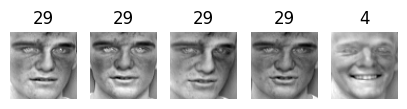

Cluster 1


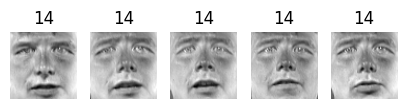

Cluster 2


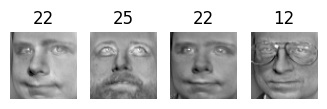

Cluster 3


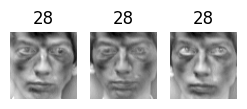

Cluster 4


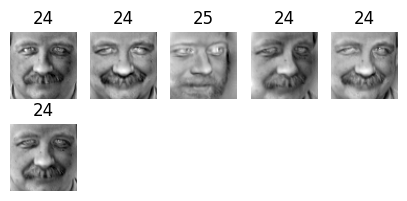

Cluster 5


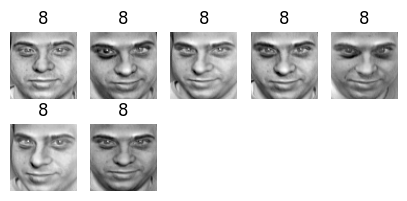

Cluster 6


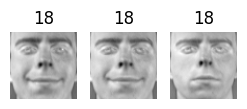

Cluster 7


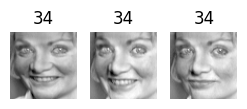

Cluster 8


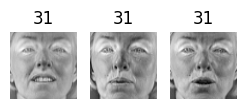

Cluster 9


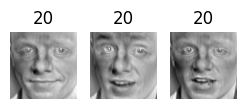

In [27]:
# Mostrar los 10 primeros clusters
for cluster_id in range(10):

    # índices de imágenes pertenecientes al cluster
    idx = np.where(cluster_labels == cluster_id)[0]

    # seleccionar algunas imágenes (ej: primeras 10)
    faces_sample = X_train.iloc[idx[:10]].values
    labels_sample = y_train.iloc[idx[:10]].values

    print(f"Cluster {cluster_id}")
    plot_faces(faces_sample, labels_sample)


Se visualizan las imágenes originales asignadas a los primeros clusters para evaluar visualmente la coherencia del agrupamiento. Aunque el modelo se entrenó sobre datos transformados mediante PCA, la visualización se realiza con las imágenes originales

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Crear modelo RandomForest
rf = RandomForestClassifier(
    n_estimators=150,     # número de árboles
    random_state=42       # reproducibilidad
)

# Entrenar modelo
rf.fit(X_train, y_train)   # aprendizaje supervisado

# Predecir sobre validación
y_pred = rf.predict(X_val)

# Evaluar accuracy
acc = accuracy_score(y_val, y_pred)

print("Accuracy en validación:", acc)


Accuracy en validación: 0.925


Se entrena un modelo RandomForest para realizar clasificación supervisada utilizando las etiquetas reales del dataset. El modelo se evalúa sobre el conjunto de validación para comparar posteriormente el rendimiento frente al clustering no supervisado.  
NO hace falta usar PCA con RandomForest porque RandomForest: trabaja con arboles y no usa distancias como Kmeans y no sufre tanto por muchas dimensiones  
Aunque se aplicó PCA previamente para mejorar el clustering con KMeans, no se utiliza para RandomForest ya que los modelos basados en árboles no requieren reducción dimensional y pueden manejar datasets de alta dimensión de forma eficiente.  

El modelo RandomForest alcanza un accuracy aproximado del 92.5% en el conjunto de validación, indicando una alta capacidad para identificar correctamente a las personas en las imágenes. Este resultado es significativamente superior al clustering no supervisado, lo cual es esperable ya que el modelo supervisado utiliza etiquetas reales durante el entrenamiento.

### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [29]:
# Transformar usando KMeans (distancia a centroides)

X_train_reduced = best_model.transform(X_train_pca)   # Train reducido
X_val_reduced = best_model.transform(X_valid_pca)     # Valid reducido
X_test_reduced = best_model.transform(X_test_pca)     # Test reducido


In [30]:
from sklearn.ensemble import RandomForestClassifier   # Importar modelo RandomForest
from sklearn.metrics import accuracy_score            # Importar métrica accuracy

rf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)   # Crear modelo con 150 árboles

rf_reduced.fit(X_train_reduced, y_train)   # Entrenar modelo con datos transformados por KMeans

y_pred_reduced = rf_reduced.predict(X_val_reduced)   # Predecir etiquetas en conjunto de validación

acc_reduced = accuracy_score(y_val, y_pred_reduced)  # Calcular accuracy comparando predicción vs real

print("Accuracy con KMeans transform:", acc_reduced) # Mostrar resultado final


Accuracy con KMeans transform: 0.75


Se utiliza KMeans como método de transformación de características, empleando las distancias a los centroides como nuevas variables de entrada para entrenar un modelo RandomForest.   
1️⃣ RandomForest con píxeles originales → accuracy 0.925  
2️⃣ RandomForest con features creadas por clustering. 0.75  

El accuracy disminuye al utilizar las distancias a centroides como nuevas características, lo cual es esperable debido a la reducción de información respecto a los datos originales. Sin embargo, el modelo mantiene un rendimiento razonable, indicando que la transformación mediante KMeans conserva parte de la estructura relevante del dataset.  
Se utiliza accuracy como métrica de evaluación al tratarse de un problema de clasificación supervisada con clases relativamente balanceadas, permitiendo comparar fácilmente el rendimiento entre distintos modelos.

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

In [31]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

k_values = range(5,151,5)   # probar distintos K
acc_scores = []              # guardar accuracies

for k in k_values:

    # Crear y entrenar KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)

    # Transformar datasets (distancia a centroides)
    X_train_red = kmeans.transform(X_train_pca)
    X_val_red = kmeans.transform(X_valid_pca)

    # Entrenar RandomForest aprende usando esas distancias
    rf = RandomForestClassifier(n_estimators=150, random_state=42)
    rf.fit(X_train_red, y_train)

    # Evaluar accuracy
    y_pred = rf.predict(X_val_red)
    acc = accuracy_score(y_val, y_pred)

    acc_scores.append(acc)

# Obtener mejor K
best_k_extra = k_values[acc_scores.index(max(acc_scores))]

print("Mejor K (según accuracy):", best_k_extra)
print("Mejor accuracy:", max(acc_scores))


Mejor K (según accuracy): 135
Mejor accuracy: 0.85


Método	Accuracy
RandomForest original	0.925
KMeans transform (K=105)	0.75
KMeans transform optimizado (K=135)	0.85  
👉 Cuando aumentas K:

creas más centroides.  
tienes más información para describir las caras.  
Esto mejora la clasificación.  


Se observa que el valor óptimo de K para clasificación (K=135) difiere del obtenido mediante silhouette score, lo que indica que el número óptimo de clusters depende del objetivo del análisis. Al aumentar el número de centroides, se mejora la representación de los datos para el clasificador, incrementando el accuracy.